In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

import getdist.plots as gdplt
from cobaya.model import get_model
from cobaya import run

# Section 1: Simple example

In this first section, we learn the basics of Cobaya. Let's say that we have data points and want to perform a linear regression such that our model is
$y=\alpha x + \beta$. We will firstly generate random data and use Cobaya to fit $\alpha$ and $\beta$. On top of that, let's pretend that the value (called $\gamma$) of $y(x=1)$ is of physical interest and let's make it a derived parameter.

In [2]:
# Define the model

def my_model(x, alpha, beta):
    return alpha * x + beta

In [3]:
# Choose values for alpha, beta and add some Gaussian noise with amplitude epsilon

alpha = 1.
beta = 0.5
epsilon = 0.05

# Create data

x_data = np.linspace(0, 1, 30)
y_data = my_model(x_data, alpha, beta) + np.random.normal(0, epsilon, len(x_data))

# Compute covariance (assuming data to be uncorrelated)

cov = np.diag(epsilon**2*np.ones(len(x_data)))
inv_cov = np.linalg.inv(cov)

<IPython.core.display.Javascript object>


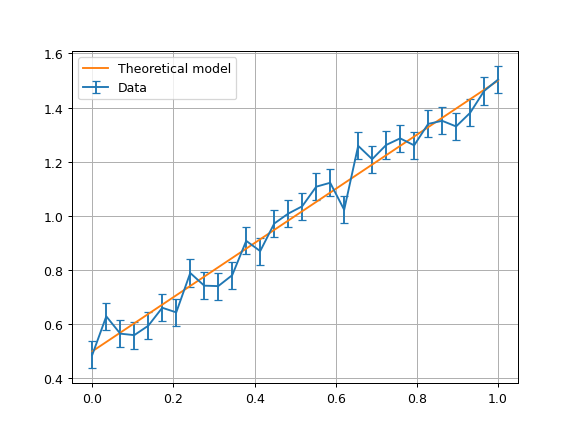

In [4]:
# This is how our synthetic data look like as well as the theoretical, noiseless, underlying model

plt.figure()
plt.errorbar(x_data,y_data,np.sqrt(np.diag(cov)), capsize=3, label="Data")
plt.plot(x_data,my_model(x_data, alpha, beta), label="Theoretical model")
plt.grid()
plt.legend()

In [5]:
# Create a function that returns the Gaussian log-likelihood

def my_log_likelihood(alpha, beta):
    
    y_theoretical = my_model(x_data, alpha, beta)
    log_like = -0.5*(y_data-y_theoretical)@inv_cov@(y_data-y_theoretical).T
    
    return log_like

# Create a function that returns the derived parameters

def my_gamma(alpha, beta):
    gamma = my_model(1., alpha, beta)
    return gamma
    

In [6]:
# Create the cobaya info dictionary

info = {}

info["likelihood"] = {"experiment": my_log_likelihood}

info["params"] = {
    "alpha": {
        "prior": {"min": 0, "max": 2},
        "ref": 0.5,
        "proposal": 0.1,
        "latex": r"\alpha"
    },
    "beta": {
        "prior": {"min": 0, "max": 2},
        "ref": 0.3,
        "proposal": 0.1,
        "latex": r"\beta"
     },
    "gamma": {
        "derived": my_gamma,
        "latex": r"\gamma"
    }
}

info["sampler"] = {
    "mcmc": {
        "Rminus1_stop": 0.01,
        "max_tries": 1000
    }
}


In [7]:
# Test our cobaya model before running the mcmc

model = get_model(info)

# Choose a random point to perform tests

random_point = model.prior.sample(ignore_external=True)[0]

print("Our random point is:", random_point)

# Look at the log-prior, log-likelihoods, derived parameters and log-posterior
print("The log-prior is:", model.logprior(random_point))
print("The log-likelihoods and derived parameters are:",
      model.loglikes(random_point))

print("The log-posterior is:", model.logpost(random_point))

[model] *WARNING* Ignored blocks/options: ['sampler']
[experiment] Initialized external likelihood.
Our random point is: [0.69788418 1.07718419]
The log-prior is: -1.3862943611198906
The log-likelihoods and derived parameters are: (array([-1172.86053843]), [1.775068373980631])
The log-posterior is: -1174.2468327949725


In [8]:
# Run the mcmc!

updated_info, sampler = run(info)

[experiment] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: alpha:0.5, beta:0.3
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {experiment: 39000.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-08-29 14:54:17 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.045
[mcmc]  - Convergence of means: R-1 = 0.154596 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.091
[mcmc]  - Convergence of means: R-1 = 0.049557 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Ac

In [9]:
# Extract the samples, provide right format for getdist and remove burn-in

gd_sample = sampler.products(to_getdist=True, skip_samples=0.3)["sample"]

[root] *WARNING* outlier fraction 0.1092436974789916 


<IPython.core.display.Javascript object>


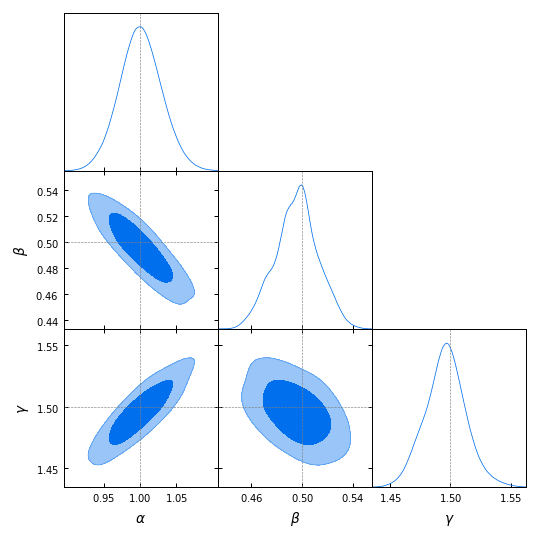

In [10]:
# Make triangle plot

gamma_theoretical = my_gamma(alpha, beta)

gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot(gd_sample, ["alpha", "beta", "gamma"], filled=True, 
                     markers={'alpha': alpha, 'beta': beta, 'gamma': gamma_theoretical})

Even if up to now and in the following sections we will always define the info dictionary through python, it is in practice more common to use yaml files and likelihoods defined in their own python files. I provided all the required files for the simple example we've just done. In more detail:

- The model and likelihood functions we wrote above are replaced by the **simple_likelihood.py** file. Take some time to have a look at it.
- The data and covariance matrix have already been computed and are loaded by the likelihood file.
- The info dictionary is replaced by the simple_likelihood.yaml file. Beware some values are missing!

Can you run the MCMC and find the values of $\alpha$ and $\beta$ I used to generate the data file?

In [23]:
updated_info, sampler = run('simple_model.yaml')

[output] Output to be read-from/written-into folder '.', with prefix 'simple_model'
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[mcmc] Initial point: alpha:1.51001, beta:0.3690951
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {simple_likelihood: 47900.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-08-29 14:55:53 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.030
[mcmc]  - Convergence of means: R-1 = 1.552567 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.073
[mcmc]  - Co

[root] *WARNING* outlier fraction 0.05201863354037267 


<IPython.core.display.Javascript object>


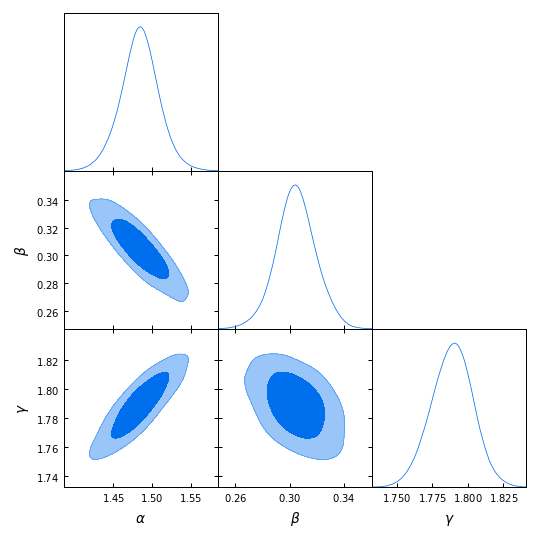

In [26]:
gd_sample = sampler.products(to_getdist=True, skip_samples=0.3)["sample"]

gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot(gd_sample, ["alpha", "beta", "gamma"], filled=True)

# Section 2: Oversampling, dragging

In many cases, cosmological likelihoods can be split into several pieces that can have very different execution times. Some parameters may only contribute to the fastest likelihoods and Cobaya has two different interesting techniques that allow to take advantage from those "fast parameters" to make the chains converge faster. Those two techniques are called "oversampling" and "dragging". 

In this section, we will see how to use those techniques with Cobaya. We first consider an example based on the fibonacci sequence where the likelihood takes a few seconds to run and then use the oversampling and dragging methods to speed up the convergence of the chain.

Let's assume that we have two independent observations $x$ and $y$. We know that we can theoretically modeled the two observations as follow:

$x = \alpha*\beta$ where $\alpha$ and $\beta$ are the two parameters we want to estimate.

$y=\Phi_n(\alpha)$ where $\Phi_n$ is the $n^\rm{th}$ element of the Fibonacci sequence and depends on the initial condition which for theoretical reasons is $\alpha$.

In [11]:
# We define the fiducial values used to generate the data

alpha = 1
beta = 2
n = 27

def fibo(n, alpha):
    if n < 2:
        return alpha
    else:
        return fibo(n-1, alpha) + fibo(n-2, alpha)

# We generate the data
x = alpha*beta
y = fibo(n, alpha)
data = np.array([x, y])

# We have this covariance matrix for those observations
cov = np.diag([1e-4, 1e7])
inv_cov = np.linalg.inv(cov)

In [12]:
# We then define the log-likelihood:

def my_log_likelihood(alpha, beta):
    
    theory = [alpha*beta, fibo(n, alpha)]
    log_like = -0.5*(data-theory)@inv_cov@(data-theory).T
    
    return log_like

In [13]:
# We define the info dictionary

info = {}

info["likelihood"] = {"experiment": my_log_likelihood}

info["params"] = {
    "alpha": {
        "prior": {"min": 0.9, "max": 1.1},
        "ref": 1.,
        "proposal": 0.0001,
        "latex": r"\alpha"
    },
    "beta": {
        "prior": {"min": 0, "max": 10},
        "ref": 2.,
        "proposal": 0.01,
        "latex": r"\beta"
     }
}

info["sampler"] = {
    "mcmc": {
        "Rminus1_stop": 0.1,
        "max_tries": 1000
    }
}

In [14]:
# Run the mcmc and time it
import time

t1 = time.time()
updated_info, sampler = run(info)
t2 = time.time()
print(t2-t1)

[experiment] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: alpha:1, beta:2
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {experiment: 14.5}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-08-23 16:06:43 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.435
[mcmc]  - Convergence of means: R-1 = 8.929872 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.489
[mcmc]  - Convergence of means: R-1 = 2.011618 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptanc

We will now use the oversampling and dragging methods to speed up the convergence. 

**Task:** 
Create two different likelihoods for the two observations $x$ and $y$ and re-run the MCMC. By default, Cobaya will automatically detect if one likelihood is faster than the other and will apply the oversampling method if that is relevant. Then, to use the dragging method instead, set the 'drag' flag to True in the 'mcmc' dictionary.

In [15]:
# We define a simple model with two parameters alpha and beta

x = alpha*beta
y = fibo(n, alpha)
sigma1 = np.sqrt(cov[0,0])
sigma2 = np.sqrt(cov[1,1])


def my_log_likelihood1(alpha, beta):
    
    x_th = alpha*beta
    log_like = -0.5*(x-x_th)**2/sigma1**2
    
    return log_like

def my_log_likelihood2(alpha):
    
    y_th = fibo(n, alpha)
    log_like = -0.5*(y_th-y)**2/sigma2**2
    
    return log_like




In [16]:
info = {}

info["likelihood"] = {"observation1": my_log_likelihood1,
                      "observation2": my_log_likelihood2}

info["params"] = {
    "alpha": {
        "prior": {"min": 0.9, "max": 1.1},
        "ref": 1.,
        "proposal": 0.0001,
        "latex": r"\alpha"
    },
    "beta": {
        "prior": {"min": 0, "max": 10},
        "ref": 2.,
        "proposal": 0.01,
        "latex": r"\beta"
     }
}

info["sampler"] = {
    "mcmc": {
        "Rminus1_stop": 0.1,
        "max_tries": 1000
    }
}

In [17]:
# Run the mcmc!

t1 = time.time()
updated_info, sampler = run(info)
t2 = time.time()
print(t2-t1)

[observation1] Initialized external likelihood.
[observation2] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: alpha:1, beta:2
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {observation1: 84300.0, observation2: 15.4}
[mcmc] Oversampling with factors:
[mcmc] * 1 : ['alpha']
[mcmc] * 8 : ['beta']
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-08-23 16:10:07 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.970
[mcmc]  - Convergence of means: R-1 = 2.534708 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.934
[mcmc]  - Convergence of means: R-1 = 0.092665

In [18]:
info['sampler']['mcmc']['drag'] = True

In [19]:
# Run the mcmc!

t1 = time.time()
updated_info, sampler = run(info)
t2 = time.time()
print(t2-t1)

[observation1] Initialized external likelihood.
[observation2] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: alpha:1, beta:2
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {observation1: 91000.0, observation2: 13.6}
[mcmc] Dragging with number of interpolating steps:
[mcmc] * 1 : [['alpha']]
[mcmc] * 8 : [['beta']]
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-08-23 16:10:33 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 40 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 1.995680 after 32 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.955
[mcmc]  - Convergence of 

# Section 3: Interaction with CAMB

In Cobaya, you can create theory classes which can then be used by the likelihoods you create to compute relevant quantities to model the observations you want to fit. In the case of the CMB for instance, CAMB is used to model the power spectra which can then be compared to the observations inside your likelihoods. In Cobaya, a CAMB wrapper has already been implemented so that you can directly specify 'camb' in the 'theory' field of the info dictionary. In this section, we will see in more details how it goes.

In [20]:
# We define cosmological parameters here

H0 = 67.5
ombh2 = 0.02242
omch2 = 0.11933
tau = 0.0561
As = 2.105e-9
ns = 0.9665

**Task :**
Use camb to generate some synthetic data (for instance, only TT power spectra with lmax=2000). In order to gain some execution time, you can specify:
- AccuracyBoost=0.6
- NonLinear='NonLinear_none'
when setting parameters. Those degraded options will speed up the code.

In [21]:
import camb

# Compute power spectra

lmax = 2000
pars = camb.set_params(H0=H0, ombh2=ombh2, omch2=omch2, tau=tau, As=As, ns=ns, 
                       lmax=lmax, AccuracyBoost=0.6, NonLinear='NonLinear_none')
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra()

In [22]:
# Compute a covariance matrix. Let's assume a full-sky cosmic-variance limited survey

ls = np.arange(powers['total'].shape[0])[2:lmax]
cl_tt = powers['total'][2:lmax,0]
cov = np.diag(2/(2*(ls+1))*cl_tt**2)
inv_cov = np.linalg.inv(cov)

<IPython.core.display.Javascript object>


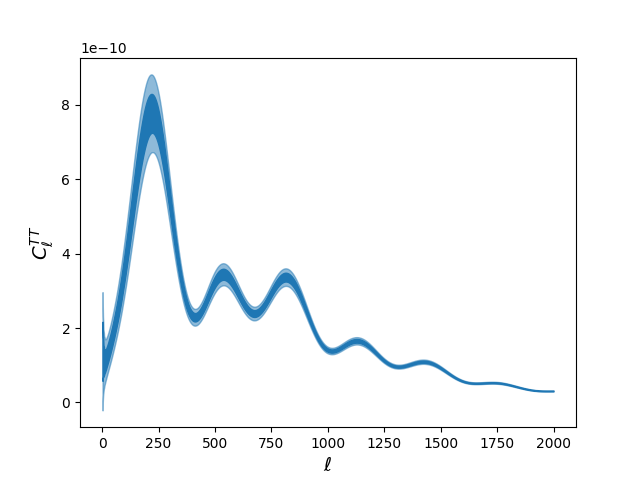

<IPython.core.display.Javascript object>


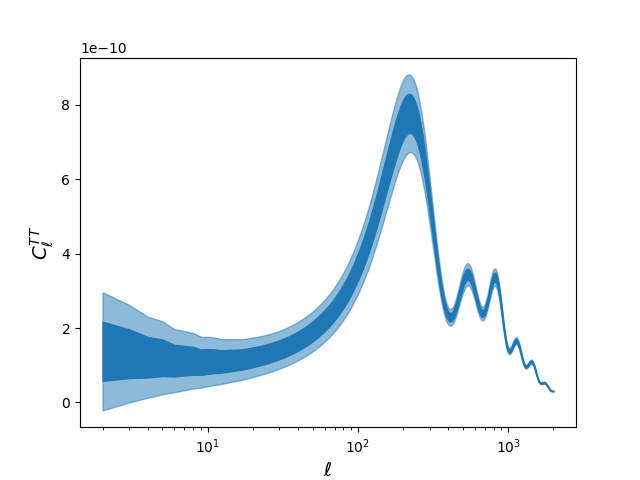

Text(0, 0.5, '$C_\\ell^{TT}$')

In [23]:
# Plot
sigma = np.diag(np.sqrt(cov))
plt.figure()
plt.fill_between(ls, cl_tt-sigma, cl_tt+sigma, color='C0', alpha=1)
plt.fill_between(ls, cl_tt-2*sigma, cl_tt+2*sigma, color='C0', alpha=0.5)
plt.xlabel(r"$\ell$", fontsize=14)
plt.ylabel(r"$C_\ell^{TT}$", fontsize=14)

plt.figure()
plt.fill_between(ls, cl_tt-sigma, cl_tt+sigma, color='C0', alpha=1)
plt.fill_between(ls, cl_tt-2*sigma, cl_tt+2*sigma, color='C0', alpha=0.5)
plt.semilogx()
plt.xlabel(r"$\ell$", fontsize=14)
plt.ylabel(r"$C_\ell^{TT}$", fontsize=14)

In [24]:
# We create a Likelihood class. Note that the logp method must always be defined 
# while initialize and get_requirements are optional

from cobaya.likelihood import Likelihood

class my_likelihood_class(Likelihood):

    def initialize(self):
        self.data = cl_tt
        self.inv_covmat = inv_cov
        self.lmin = 2
        self.lmax = lmax
        
    # The get_requirements method is used to specify what the likelihood needs the theory class to provide
    # Here we need CAMB to provide the TT power spectra up to l=lmax
    def get_requirements(self):
        return {'Cl': {'tt': lmax}}

    # Here we compute the log-likelihood
    def logp(self, **params_values):
        cls = self.provider.get_Cl(ell_factor=True, units="1") 
        # This is known because we requested it in get_requirements
        
        diff_vec = (cls['tt'][self.lmin:self.lmax]-self.data)
        chi2 = diff_vec@self.inv_covmat@diff_vec.T
        return - chi2 / 2                                                

In [25]:
# Let's say we only want to sample w, the equation of state parameter of dark energy

info = {}

info['theory'] = {'camb': 
                     {'extra_args': {
                         'ombh2': ombh2,
                         'omch2': omch2,
                         'tau': tau,
                         'As': As,
                         'ns': ns,
                         'H0': H0,
                         'AccuracyBoost': 0.6,
                         'NonLinear': 'NonLinear_none',
                         'lmax': lmax,
                         'dark_energy_model': 'DarkEnergyPPF'
                         }
                     }
                 }

info["likelihood"] = {'experiment': my_likelihood_class}

info["params"] = {
    "w": {
        "prior": {"min": -3, "max": 3},
        "ref": -1,
        "proposal": 0.001,
        "latex": r"w"
    }
}

info["sampler"] = {
    "mcmc": {
        # We modify the convergence criteria so that the run is not too long
        "Rminus1_stop": 0.25,
        "Rminus1_cl_stop": 0.5,
        "max_tries": 1000
    }
}

In [26]:
# For your information (also useful for following sections), this is what CAMB can provide

model = get_model(info)

# Those are the parameters that CAMB can provide (in a likelihood class for instance)
print(model.theory['camb'].get_can_provide_params())

# Those are the functions of CAMB that can be called (in a likelihood class for instance)
print(model.theory['camb'].get_can_provide_methods())

[model] *WARNING* Ignored blocks/options: ['sampler']
[camb] `camb` module loaded successfully from /Users/kou/Documents/Professionnel/Sussex/CAMB/camb
{'omegabh2', 'zdrag', 'YHe', 'omegal', 'omegac', 'omega_de', 'omegab', 'DH', 'kd', 'zstar', 'yheused', 'omegam', 'sigma8', 'TCMB', 'zre', 'yhe', 'thetastar', 'age', 'H0', 'omeganu', 'omegak', 'omk', 'thetarseq', 'keq', 'As', 'Y_p', 'omegach2', 'DAstar', 'N_eff', 'thetaeq', 'zeq', 'thetad', 'omnuh2', 'rdrag', 'omch2', 'rstar', 'ombh2', 'YpBBN', 'zrei', 'h'}
{'CAMBdata': <function CAMB.get_CAMBdata at 0x7fc13d74c430>, 'Cl': <function CAMB.get_Cl at 0x7fc13d74c1f0>, 'Hubble': <function BoltzmannBase.get_Hubble at 0x7fc13d504820>, 'Omega_b': <function BoltzmannBase.get_Omega_b at 0x7fc13d5048b0>, 'Omega_cdm': <function BoltzmannBase.get_Omega_cdm at 0x7fc13d504940>, 'Omega_nu_massive': <function BoltzmannBase.get_Omega_nu_massive at 0x7fc13d5049d0>, 'Pk_grid': <function BoltzmannBase.get_Pk_grid at 0x7fc13d504ca0>, 'Pk_interpolator': <funct

In [27]:
updated_info, sampler = run(info)

[camb] `camb` module loaded successfully from /Users/kou/Documents/Professionnel/Sussex/CAMB/camb
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: w:-1
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {experiment: 1040.0, camb.transfers: 2.93, camb: 57.1}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-08-23 16:11:14 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 40 samples accepted.
[mcmc]  - Acceptance rate: 0.571
[mcmc]  - Convergence of means: R-1 = 0.533657 after 32 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.552
[mcmc]  - Convergence of means: R-1 = 0.336312 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


[root] *WARNING* outlier fraction 0.12142857142857143 


<IPython.core.display.Javascript object>


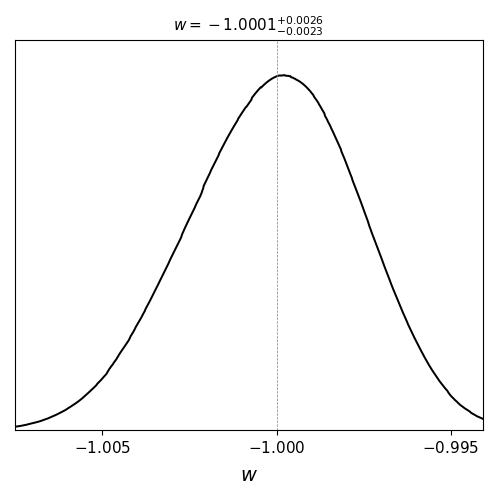

[root] *WARNING* auto bandwidth for chi2 very small or failed (h=0.002539076310495876,N_eff=85.72957034540859). Using fallback (h=0.015248638698358057)


In [28]:
gd_sample = sampler.products(to_getdist=True, skip_samples=0.3)["sample"]

gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.plot_1d(gd_sample, "w", title_limit=1)
gdplot.add_x_marker(-1)

# Section 4 : Use cobaya's included likelihoods. Example: Planck

Cobaya has a number of already implemented likelihoods. For instance, you can directly used the latest Planck likelihood without any effort. In particular, the calibration and nuisance parameters will be automatically added, together with the priors and proposal values!

In [29]:
# Let's say we also want to constrain w, this time using the Planck likelihood, taking into account all
# the calibration and nuisance parameters

info = {}

info['theory'] = {'camb': 
                     {'extra_args': {
                         'ombh2': ombh2,
                         'omch2': omch2,
                         'tau': tau,
                         'As': As,
                         'ns': ns,
                         'H0': H0,
                         'AccuracyBoost': 0.6,
                         'NonLinear': 'NonLinear_none',
                         'lmax': lmax,
                         'dark_energy_model': 'DarkEnergyPPF'
                         }
                     }
                 }

info["likelihood"] = {'planck_NPIPE_highl_CamSpec.TTTEEE': None}

info["params"] = {
    "w": {
        "prior": {"min": -3, "max": 0},
        "ref": -1.,
        "proposal": 0.001,
        "latex": r"w_0"
    }
}

# To gain some time, an initial covariance matrix is provided
covmat = np.load("covmat_w_Planck.npy")

info["sampler"] = {
    "mcmc": {
        # We also modify the convergence criteria so that the run is not too long
        "Rminus1_stop": 0.5,
        "Rminus1_cl_stop": 0.5,
        "max_tries": 1000,
        "learn_proposal_Rminus1_max": 0.4,
        # Below we specify the covariance matrix as well as the order in which the parameters are
        # stored in the covariance matrix. You can see that indeed there is not only w 
        # but also some calibration and nuisance parameters
        "covmat": covmat,
        "covmat_params": ['w','A_planck', 'amp_143', 'amp_217', 'amp_143x217', 'n_143', 'n_217', 'n_143x217', 'calTE', 'calEE']
    }
}

In [30]:
# Pay attention to the fact that Cobaya is automatically using oversampling!

updated_info, sampler = run(info)

[camb] `camb` module loaded successfully from /Users/kou/Documents/Professionnel/Sussex/CAMB/camb
[planck_npipe_highl_camspec.ttteee] L-range for 143x143: 30 2000
[planck_npipe_highl_camspec.ttteee] L-range for 217x217: 500 2500
[planck_npipe_highl_camspec.ttteee] L-range for 143x217: 500 2500
[planck_npipe_highl_camspec.ttteee] L-range for TE: 30 2000
[planck_npipe_highl_camspec.ttteee] L-range for EE: 30 2000
[planck_npipe_highl_camspec.ttteee] Number of data points: 9915
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: w:-1, A_planck:1.002221, amp_143:10.36477, amp_217:21.29657, amp_143x217:10.57531, n_143:0.8530293, n_217:0.5409224, n_143x217:0.6979948, calTE:0.9985363, calEE:1.004145
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {planck_NPIPE_highl_CamSpec.TTTEEE: 92.7, camb.transfers: 3.11, camb: 47.0}
[mcmc] Oversampling with factors:
[mcmc] * 1 : ['w']
[mcmc] * 3 : ['A_planck', 'amp_143', 

[root] *WARNING* outlier fraction 0.020634920634920634 


<IPython.core.display.Javascript object>


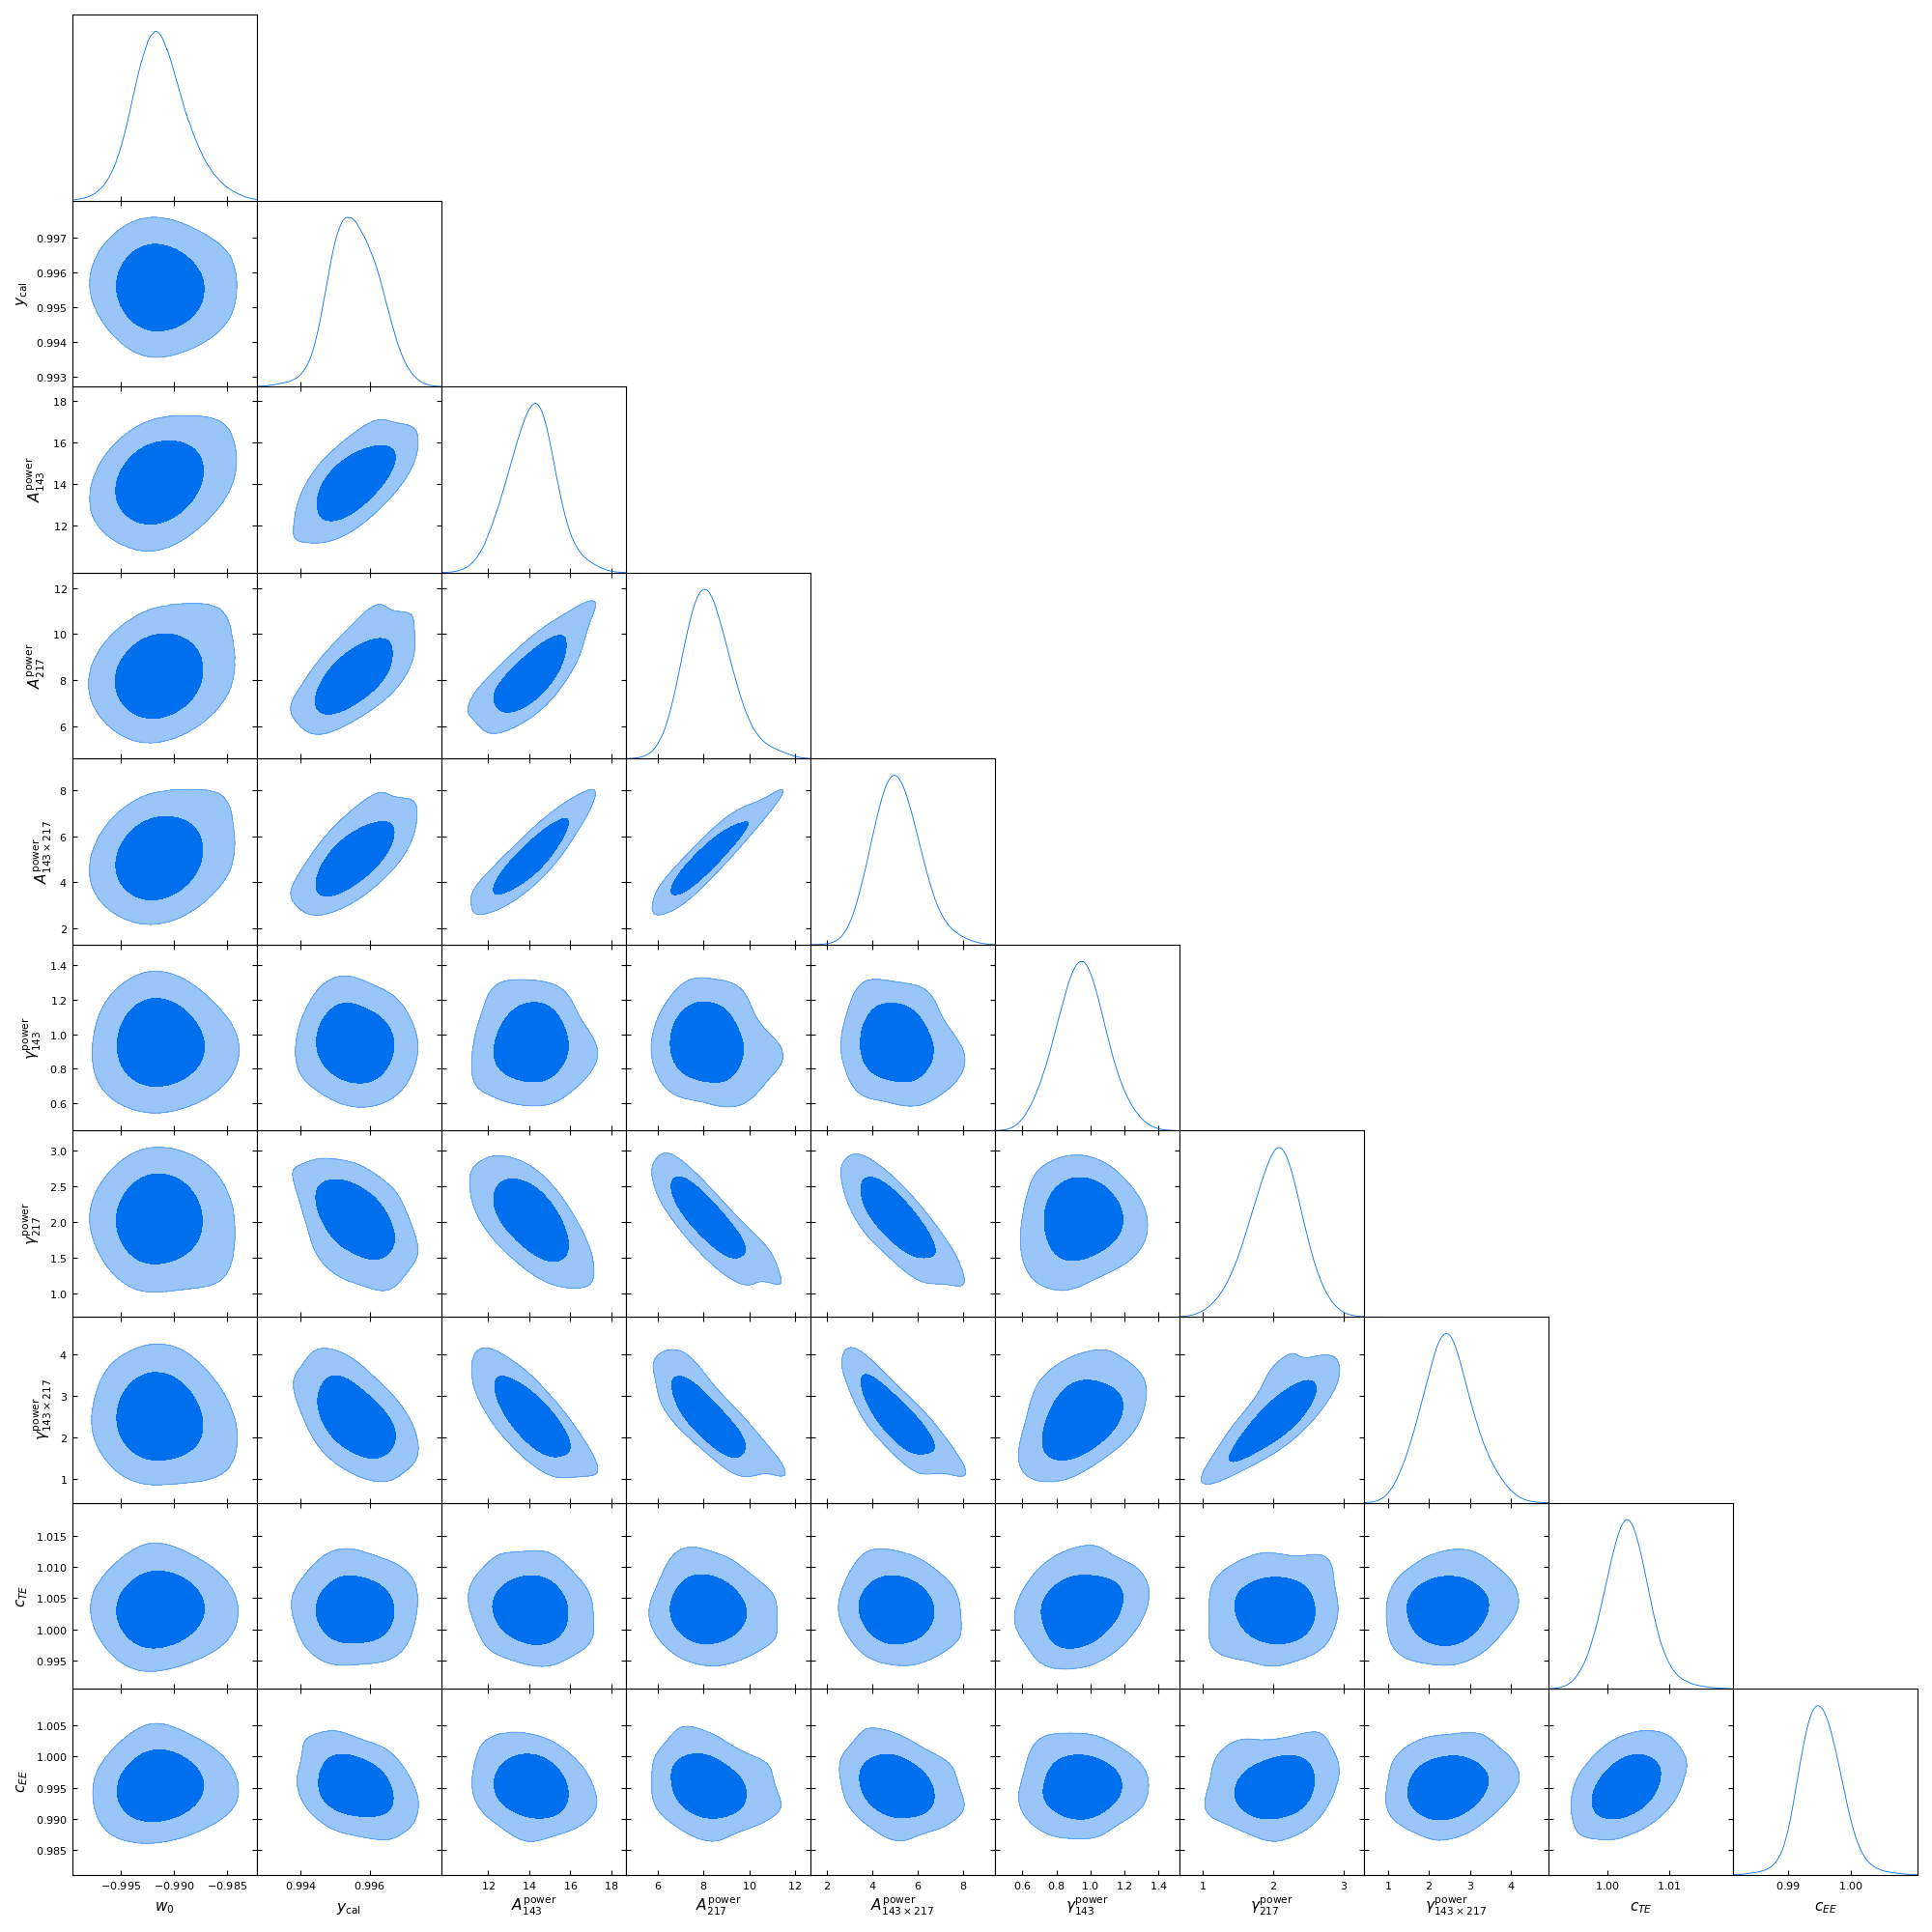

In [31]:
gd_sample = sampler.products(to_getdist=True, skip_samples=0.3)["sample"]

gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot(gd_sample, 
    ['w','A_planck', 'amp_143', 'amp_217', 'amp_143x217', 'n_143', 'n_217', 'n_143x217', 'calTE', 'calEE'], 
    filled=True)

# Section 5: Write your own (more advanced) likelihood class

In this more advanced section, we will use what we have used so far to put some constraints on four parameters, namely: 
- the Hubble constant $H_0$
- the dark matter density $\omega_c=\Omega_ch^2$
- the dark energy equation of state CPL parameters $w_0$ and $w_a$ where $w(a) = w_0 + (1-a)w_a$

We will use several observations to constrain those parameters and hence perform a multi probe analysis. The probe we will consider are:
- a (very) approximate CMB likelihood
- a (very) approximate BAO likelihood
- a local measurement of $H_0$

**Probe 1: CMB**

We could use the Planck likelihood as it is already implemented in Cobaya, however computing the power spectra through CAMB takes too much time for the purpose of this section. We assume that the CMB likelihood consists in two quantities
- the angular scale $\theta_\star=1.04109 \pm 0.0003$ which is related to the position of the first peak in the CMB power spectrum
- the redshift of recombination $z_\star = 1089.95 \pm 0.27$

**Task :**
Implement this likelihood and run the MCMC for the four parameters mentioned above. Show the triangle plot.

In [32]:
class CMB(Likelihood):

    def initialize(self):
        self.thetastar = 1.04109
        self.thetastar_error = 0.0003
        
        self.zstar = 1089.95
        self.zstar_error = 0.27
        
        self.data = np.array([self.thetastar, self.zstar])
        self.cov = np.diag([self.thetastar_error, self.zstar_error])
        self.inv_cov = np.linalg.inv(self.cov)

    def get_requirements(self):
        requisites = {'thetastar': None, 'zstar': None}
        return requisites

    def logp(self, **params_values):
        thetastar = self.provider.get_param("thetastar")
        zstar = self.provider.get_param("zstar")
        diff_vec = self.data-np.array([thetastar, zstar])
        return -0.5*diff_vec@self.inv_cov@diff_vec.T

info = {}

info['theory'] = {'camb': 
                     {'extra_args': {
                         'ombh2': ombh2,
                         'tau': tau,
                         'As': As,
                         'ns': ns,
                         'lmax': lmax,
                         'dark_energy_model': 'DarkEnergyPPF'
                         }
                     }
                 }

info["likelihood"] = {'CMB': CMB}

info["params"] = {
    'H0': {
        "prior": {"min": 50, "max": 100},
        "ref": 70.,
        "proposal": 0.1,
        "latex": r"H_0"
    },
    'omch2': {
        "prior": {"min": 0.08, "max": 0.15},
        "ref": 0.12,
        "proposal": 0.01,
        "latex": r"\Omega_c h^2"
    },
    "w": {
        "prior": {"min": -3, "max": 3},
        "ref": -1.,
        "proposal": 0.05,
        "latex": r"w_0"
    },
    'wa': {
        "prior": {"min": -3, "max": 3},
        "ref": 0.,
        "proposal": 0.05,
        "latex": r"w_a"
    }
}

info["sampler"] = {
    "mcmc": {
        "Rminus1_stop": 0.1,
        "max_tries": 1000,
    }
}

In [33]:
updated_info, sampler = run(info)

[camb] `camb` module loaded successfully from /Users/kou/Documents/Professionnel/Sussex/CAMB/camb
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: H0:70, omch2:0.12, w:-1, wa:0
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {CMB: 17300.0, camb.transfers: 51.0, camb: 25000.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-08-23 16:17:51 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.479
[mcmc]  - Convergence of means: R-1 = 9.149282 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 320 samples accepted.
[mcmc]  - Acceptance rate: 0.503
[mcmc]  - Convergence of means: R-1 = 9.581154 after 256 accepted steps
[mcmc]  - Updated covarianc

[root] *WARNING* outlier fraction 0.03316326530612245 


<IPython.core.display.Javascript object>


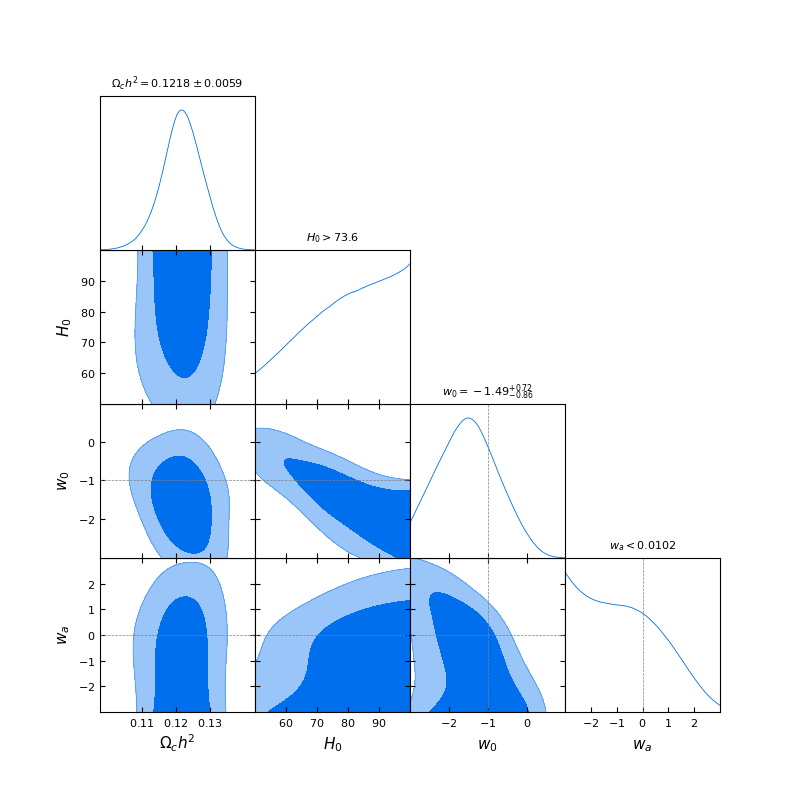

In [34]:
gd_sample = sampler.products(to_getdist=True, skip_samples=0.3)["sample"]
gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot(gd_sample, ['omch2','H0','w','wa'], filled=True, title_limit=1, markers={'w': -1, 'wa': 0})

**Probe 2: BAO**

We use data from "DESI 2024 VI: Cosmological Constraints from the Measurements of Baryon Acoustic Oscillations". We assume all the measurements to be independent. 

Here are the measurements we will use:
- $D_V/r_d(z=0.295) = 7.93 \pm 0.15$
- $D_V/r_d(z=1.491) = 26.07 \pm 0.67$

- $D_M/r_d(z=0.510) = 13.62 \pm 0.25$
- $D_M/r_d(z=0.706) = 16.85 \pm 0.32$
- $D_M/r_d(z=0.930) = 21.71 \pm 0.28$
- $D_M/r_d(z=1.317) = 27.79 \pm 0.69$
- $D_M/r_d(z=2.330) = 39.71 \pm 0.94$

- $D_H/r_d(z=0.510) = 20.98 \pm 0.61$
- $D_H/r_d(z=0.706) = 20.08 \pm 0.60$
- $D_H/r_d(z=0.930) = 17.88 \pm 0.35$
- $D_H/r_d(z=1.317) = 13.82 \pm 0.42$
- $D_H/r_d(z=2.330) = 8.52 \pm 0.17$

**Task:** 

Implement this likelihood, run the MCMC and make the triangle plot.

In [35]:
from cobaya.likelihood import Likelihood
import numpy as np

class BAO(Likelihood):

    def initialize(self):
        self.c = 3e5
        
        self.z_DV = np.array([0.295, 1.491])
        self.z_DM = np.array([0.510, 0.706, 0.930, 1.317, 2.330])
        self.z_DH = np.array([0.510, 0.706, 0.930, 1.317, 2.330])
        
        self.DV_over_rd = [7.93, 26.07]
        self.DV_error = [0.15, 0.67]
        self.DM_over_rd = [13.62, 16.85, 21.71, 27.79, 39.71]
        self.DM_error = [0.25, 0.32, 0.28, 0.69, 0.94]
        self.DH_over_rd = [20.98, 20.08, 17.88, 13.82, 8.52]
        self.DH_error = [0.61, 0.60, 0.35, 0.42, 0.17]
        
        self.data = np.concatenate((self.DV_over_rd, self.DM_over_rd, self.DH_over_rd))
        self.cov = np.diag((np.concatenate((self.DV_error, self.DM_error, self.DH_error))))
        self.inv_cov = np.linalg.inv(self.cov)

    def get_requirements(self):

        requisites = {}
        z_req = np.unique(np.concatenate((self.z_DV, self.z_DM, self.z_DH, [1090])))
        requisites['angular_diameter_distance'] = {"z": z_req}
        requisites['Hubble'] = {"z": z_req}
        requisites['rdrag'] = None
        requisites['rstar'] = None
        requisites['zstar'] = None
        
        return requisites
    
    def DV_over_rd_th(self, z):
        return np.cbrt(
                ((1 + z) * self.provider.get_angular_diameter_distance(z)) ** 2 *
                self.c * z / self.provider.get_Hubble(z,
                                                            units="km/s/Mpc")) / self.provider.get_param("rdrag")
    
    def DM_over_rd_th(self, z):
        return (1 + z) * self.provider.get_angular_diameter_distance(z) / self.provider.get_param("rdrag")
    
    def DH_over_rd_th(self, z):
        return 1 / self.provider.get_Hubble(z, units="1/Mpc") / self.provider.get_param("rdrag")


    def logp(self, **params_values):
        DV_over_rd_th = self.DV_over_rd_th(self.z_DV)
        DM_over_rd_th = self.DM_over_rd_th(self.z_DM)
        DH_over_rd_th = self.DH_over_rd_th(self.z_DH)
        
        theoretical_vec = np.concatenate((DV_over_rd_th, DM_over_rd_th, DH_over_rd_th))
        diff_vec = theoretical_vec - self.data
        
        return -0.5*diff_vec@self.inv_cov@diff_vec.T

In [36]:
# Create the cobaya info dictionnary

info = {}

info['theory'] = {'camb': 
                     {'extra_args': {
                         'ombh2': ombh2,
                         'tau': tau,
                         'As': As,
                         'ns': ns,
                         'lmax': lmax,
                         'dark_energy_model': 'DarkEnergyPPF'
                         }
                     }
                 }

info["likelihood"] = {'bao': BAO}

info["params"] = {
        'H0': {
        "prior": {"min": 50, "max": 100},
        "ref": 70.,
        "proposal": 0.1,
        "latex": r"H_0"
    },
    'omch2': {
        "prior": {"min": 0.08, "max": 0.15},
        "ref": 0.12,
        "proposal": 0.1,
        "latex": r"\Omega_c h^2"
    },
    "w": {
        "prior": {"min": -3, "max": 3},
        "ref": -1.,
        "proposal": 0.05,
        "latex": r"w_0"
    },
    'wa': {
        "prior": {"min": -3, "max": 3},
        "ref": 0.,
        "proposal": 0.05,
        "latex": r"w_a"
    },
}

info["sampler"] = {
    "mcmc": {
        "Rminus1_stop": 0.1,
        "max_tries": 1000,
    }
}

In [37]:
updated_info, sampler = run(info)

[camb] `camb` module loaded successfully from /Users/kou/Documents/Professionnel/Sussex/CAMB/camb
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: H0:70, omch2:0.12, w:-1, wa:0
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {bao: 2230.0, camb.transfers: 63.7, camb: 3330.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-08-23 16:18:56 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.146
[mcmc]  - Convergence of means: R-1 = 9.478272 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 320 samples accepted.
[mcmc]  - Acceptance rate: 0.251
[mcmc]  - Convergence of means: R-1 = 9.129217 after 256 accepted steps
[mcmc]  - Updated covariance 

[root] *WARNING* outlier fraction 0.1171875 


<IPython.core.display.Javascript object>


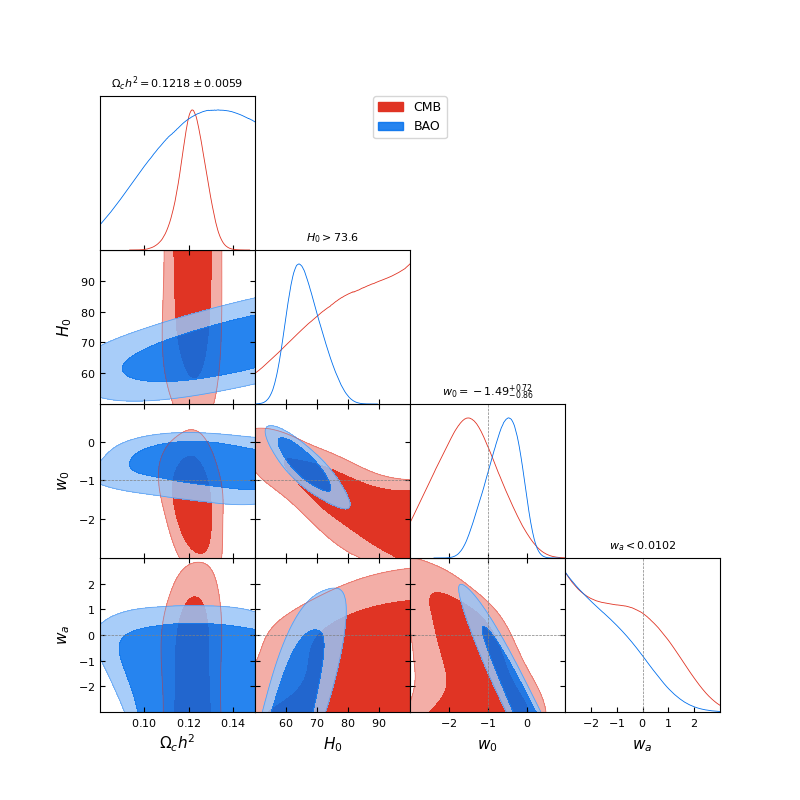

In [38]:
gd_sample_bao = sampler.products(to_getdist=True, skip_samples=0.3)["sample"]

gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot([gd_sample,gd_sample_bao], ['omch2','H0','w','wa'], legend_labels=['CMB', 'BAO'], filled=True, 
                     title_limit=1, markers={'w': -1, 'wa': 0})

In [39]:
info["likelihood"] = {'bao': BAO, 'CMB': CMB}
updated_info, sampler = run(info)

[camb] `camb` module loaded successfully from /Users/kou/Documents/Professionnel/Sussex/CAMB/camb
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: H0:70, omch2:0.12, w:-1, wa:0
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {bao: 1790.0, CMB: 42700.0, camb.transfers: 60.4, camb: 2830.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-08-23 16:19:39 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.067
[mcmc]  - Convergence of means: R-1 = 1.260172 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 320 samples accepted.
[mcmc]  - Acceptance rate: 0.140
[mcmc]  - Convergence of means: R-1 = 3.224757 after 256 accepted steps
[mcmc]  - Updat

[root] *WARNING* outlier fraction 0.035076530612244895 


<IPython.core.display.Javascript object>


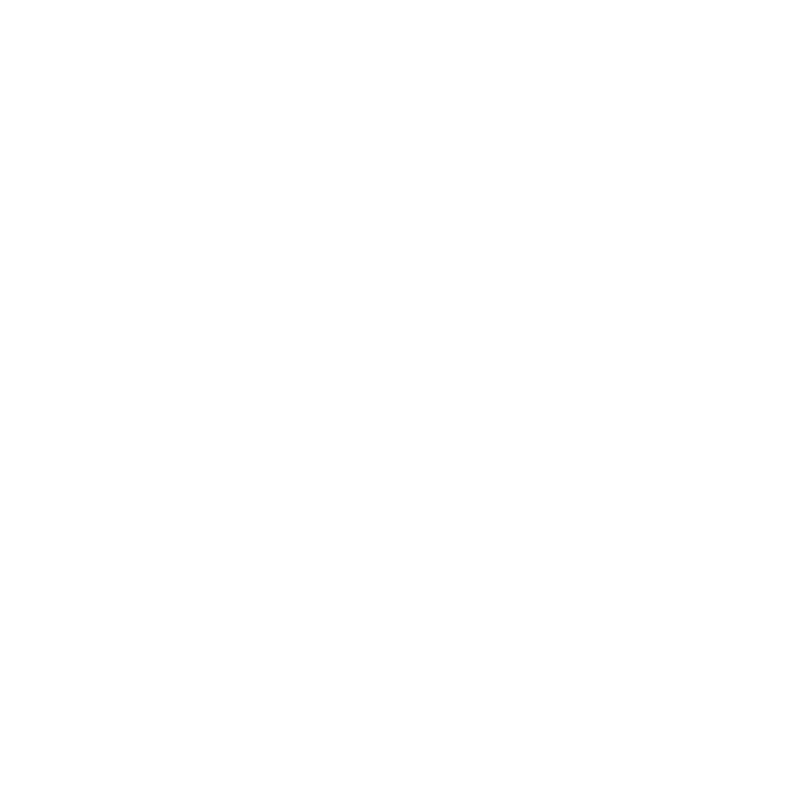

In [40]:
gd_sample_cmb_bao = sampler.products(to_getdist=True, skip_samples=0.3)["sample"]

gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot([gd_sample, gd_sample_bao, gd_sample_cmb_bao], ['omch2','H0','w','wa'], filled=True, 
                     title_limit=1, legend_labels=['CMB', 'BAO', 'CMB + BAO'], markers={'w': -1, 'wa': 0})

**Probe 3: Local measurement of $H_0$**

We finally add a last measurement which is based on the local measurement of $H_0$ with the distance-ladder method. The latest measurement (https://arxiv.org/abs/2112.04510) is 

$H_0 = 73.04 \pm 1.04$ and can be added as a Gaussian likelihood.

**Task:**

Implement this likelihood and run the MCMC with the combination of the three likelihoods (CMB + BAO + local H0), make the triangle plot.

In [41]:
# For such a simple case, no need to create a full likelihood class.

def H0_SHOES(H0):
    H0_mean = 73.04
    H0_error = 1.04
    log_like = -0.5*((H0-H0_mean)/H0_error)**2
    return log_like


info = {}

info['theory'] = {'camb': 
                     {'extra_args': {
                         'ombh2': ombh2,
                         'tau': tau,
                         'As': As,
                         'ns': ns,
                         'lmax': lmax,
                         'dark_energy_model': 'DarkEnergyPPF',
                         }
                     }
                 }

info["likelihood"] = {'bao': BAO,
                      'CMB': CMB,
                      'H0_SHOES': H0_SHOES
                     }

info["params"] = {
    'H0': {
        "prior": {"min": 50, "max": 90},
        "ref": 70.,
        "proposal": 0.1,
        "latex": r"H_0"
    },
    'omch2': {
        "prior": {"min": 0.08, "max": 0.15},
        "ref": 0.12,
        "proposal": 0.1,
        "latex": r"\Omega_c h^2"
    },
    "w": {
        "prior": {"min": -3, "max": 3},
        "ref": -1.,
        "proposal": 0.05,
        "latex": r"w_0"
    },
    'wa': {
        "prior": {"min": -3, "max": 3},
        "ref": 0.,
        "proposal": 0.05,
        "latex": r"w_a"
    }
}

info["sampler"] = {
    "mcmc": {
        "Rminus1_stop": 0.1,
        "max_tries": 1000,
    }
}

In [42]:
updated_info, sampler = run(info)

[camb] `camb` module loaded successfully from /Users/kou/Documents/Professionnel/Sussex/CAMB/camb
[h0_shoes] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: H0:70, omch2:0.12, w:-1, wa:0
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {bao: 2090.0, CMB: 51000.0, H0_SHOES: 88600.0, camb.transfers: 66.8, camb: 3430.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-08-23 16:21:20 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.246
[mcmc]  - Convergence of means: R-1 = 8.985256 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 320 samples accepted.
[mcmc]  - Acceptance rate: 0.365
[mcmc]  - Convergence of

[root] *WARNING* outlier fraction 0.0260989010989011 


<IPython.core.display.Javascript object>


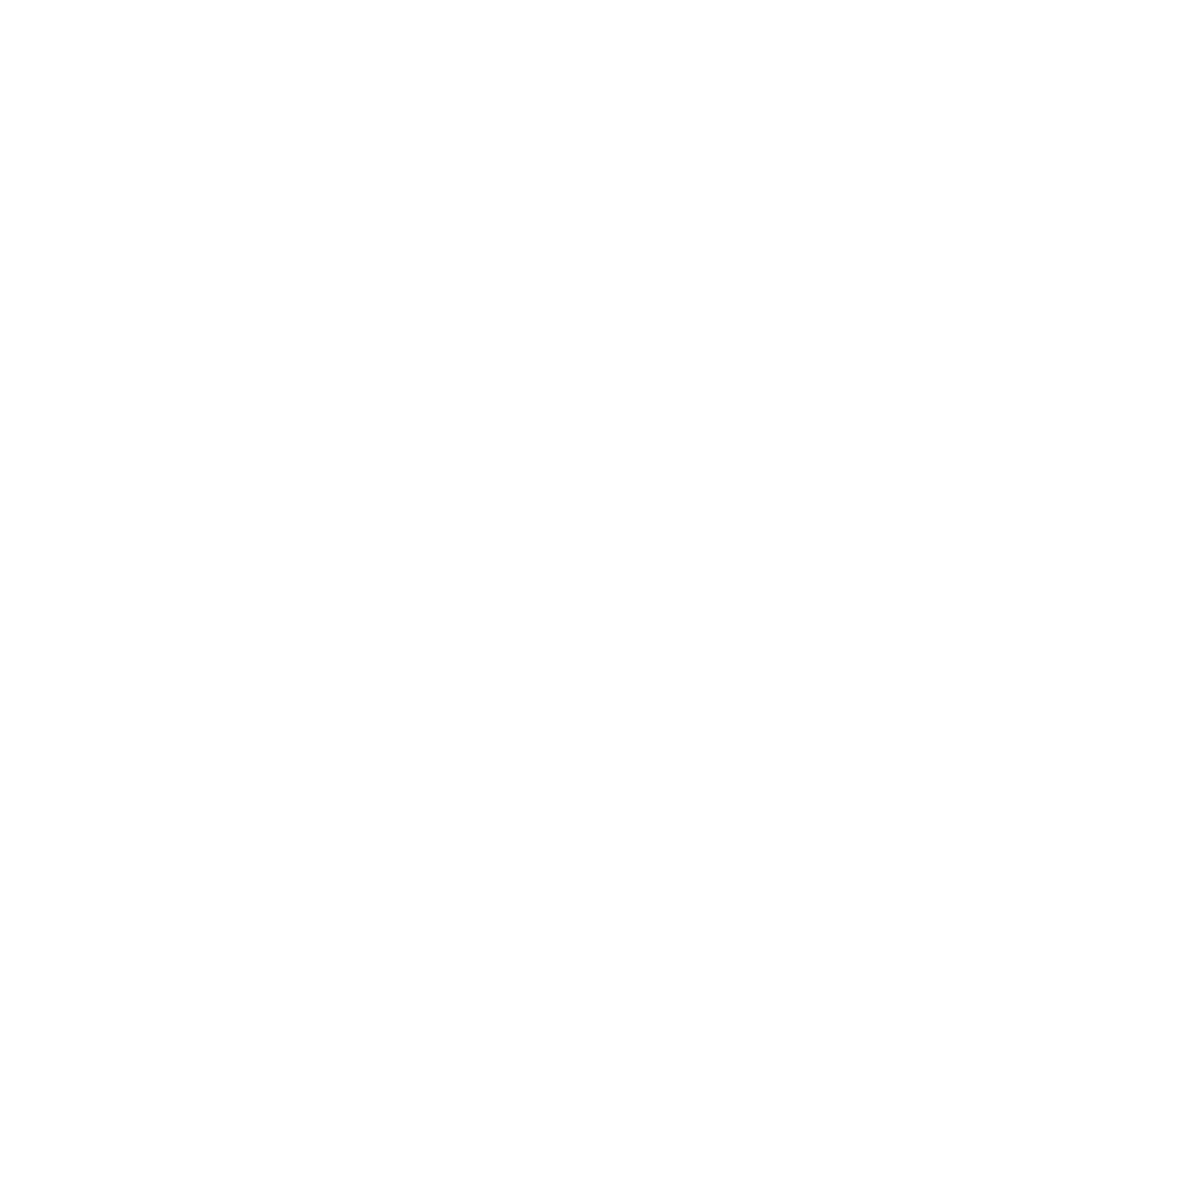

In [43]:
gd_sample_cmb_bao_H0 = sampler.products(to_getdist=True, skip_samples=0.3)["sample"]

gdplot = gdplt.get_subplot_plotter(width_inch=12)
gdplot.triangle_plot([gd_sample, gd_sample_bao, gd_sample_cmb_bao, gd_sample_cmb_bao_H0], 
                     ['omch2','H0','w','wa'], filled=True,
                     legend_labels=['CMB', 'BAO', 'CMB + BAO', 'CMB + BAO + local H0'], 
                     markers={'w': -1, 'wa': 0})

<IPython.core.display.Javascript object>


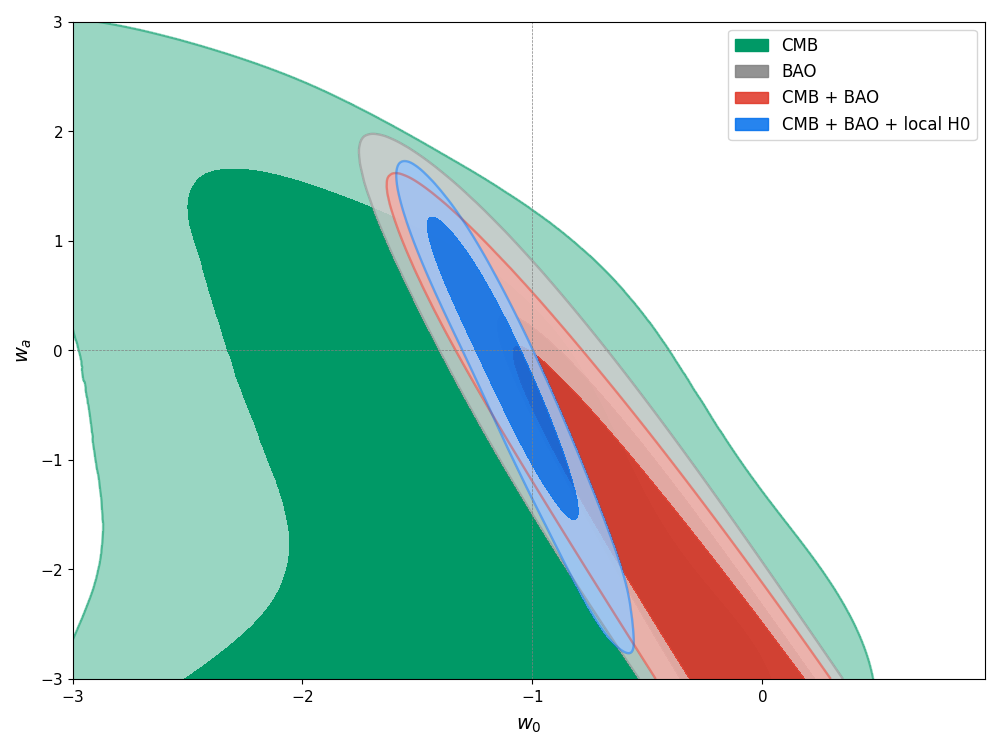

In [45]:
g = gdplt.get_single_plotter(width_inch=10)
g.plot_2d([gd_sample, gd_sample_bao, gd_sample_cmb_bao, gd_sample_cmb_bao_H0], ["w", "wa"], filled=True)
g.add_x_marker(-1)
g.add_y_marker(0)
g.add_legend(['CMB', 'BAO', 'CMB + BAO', 'CMB + BAO + local H0'])

# Bonus section: try using Cobaya for a simple model relevant to your research area